# PIT for Conditional Flows
Project idea based on [this paper](https://arxiv.org/abs/2102.10473). 

Using the `nflows` library for flow implementations.

In [35]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import math
import os

import torch.distributions as D
from scipy.stats import multivariate_normal, norm

from nde.train import train
from nde.flows import construct_maf, cdf_flow
from plot import plot_pdf_1D
from diagnostics.pp_plots import (
    cde_pit_values,
    PP_plot_1D,
    PP_vals,
    compare_pp_plots_regression,
    confidence_region_null
)
from diagnostics.localPIT_regression import (
    localPIT_regression_baseline,
    infer_r_alphas_baseline,
    localPIT_regression_grid,
    localPIT_regression_sample,
    infer_r_alphas_amortized, 
)

from data.data_generators import ConditionalGaussian1d
from data.feature_transforms import identity, first_dim_only


## CONTEXT (1D)

Consider the 1D conditional target distribution $f_{\Theta\mid X}$ with **unknown density** and we have **no samples**.

We only have access to samples from the joint distribution $f_{X,\Theta}$: $\quad (\Theta_1,X_1), \dots, (\Theta_n, X_n) \sim f_{X,\Theta}$

Our estimator $f_{Q\mid X}$ is a *Normalizing Flow* whose density is **explicitly known**. It is defined by a base distribution $p_U$ (tipically gaussian) and a bijective transformation $T_{\phi}$: 
$$U\sim p_U \rightarrow Q=T_{\phi}(U, X) \sim f_{Q\mid X}$$ 
$$f_{Q\mid X}(q) = p_{U}\left(T_{\phi}^{-1}(q, X)\right)\left|\operatorname{det} J_{T_{\phi}^{-1}}(q, X)\right|$$ 

Note that we can also define it's c.d.f. explicitly for a fixed $X=x_0$: $\quad F_{Q\mid X=x_0}(q) = \mathbb{P}(Q\leq q \mid X=x_0) =\mathbb{P}(T_{\phi}(U, x_0)\leq q)=\mathbb{P}(U\leq T_{\phi}^{-1}(q, x_0))=F_U(T_{\phi}^{-1}(q, x_0))$

We wish to know evaluate our estimator, with the same method as in the non-conditional case, i.e. with the PIT:

$$\text{PIT}(\theta, x ; f_{Q\mid X}) = \mathbb{P}(Q\leq \theta \mid X=x) = F_{Q \mid X=x}(\theta)$$

## EVALUATION
### True PIT-distribution / Local Consistency
For a fixed $X = x_0$ and $\Theta \sim f_{\Theta \mid X=x_0}$:
$$\begin{aligned} 
f_{Q\mid x_0} = f_{\Theta\mid x_0} & \iff \text{PIT}(\Theta, x_0 ; f_{Q\mid X})) \sim \mathcal{U}(0,1)\\
& \iff \mathbb{P}_{\Theta \mid x_0}(\text{PIT}(\Theta, x_0 ; f_{Q\mid X})) \leq \alpha) = \alpha, \quad \forall \alpha \in [0,1]\\
& \iff F_{\Theta \mid X=x_0}(F_{Q \mid X=x_0}^{-1}(\alpha)) = \alpha, \quad \forall \alpha \in [0,1]
\end{aligned}$$

We find ourselves with the same result as in the non-conditional 1D case , as $X$ is fixed at $x_0$ (cf. Theorem 2 in paper). 

**Problem:** We are unable to compute the c.d.f. of the target distribution $F_{\Theta \mid X=x_0}$, as the density $f_{\Theta \mid x_0}$ is unknown and no samples $\theta_i \mid x_0$ are available to approximate it empirically.

### Expected PIT-distribution over $X$ / Global Consistency 
We can however compute the empirical **expected c.d.f. over $X$** by using the samples from the joint distribution. 

$$\begin{aligned}
\mathbb{E}_X[F_{\Theta\mid X}(F_{Q\mid X}(\alpha)^{-1})] & = \mathbb{E}_X[\mathbb{P}_{\Theta\mid X}(F_{Q\mid X}(\Theta)\leq \alpha)]\\
& = \mathbb{E}_X[\mathbb{E}_{\Theta\mid X}[\mathbb{1}_{\{F_{Q\mid X}(\Theta)\leq \alpha\}}]]\\
& = \mathbb{E}_{\Theta, X}[\mathbb{1}_{\{F_{Q\mid X}(\Theta)\leq \alpha\}}]\\
& \approx \frac{1}{n} \sum_{i=1}^n \mathbb{1}_{\{F_{Q\mid X_i}(\Theta_i)\leq \alpha\}}
\end{aligned}$$

This gives us an approximation of the **expected (or joint) PIT-distribution:** 

$$\mathbb{E}_X[\mathbb{P}_{\Theta \mid X}(\text{PIT}(\Theta, X ; f_{Q\mid X}) \leq \alpha)] = \mathbb{P}_{\Theta,X}(\text{PIT}(\Theta, X; f_{Q\mid X})\leq \alpha) = \mathbb{E}_{\Theta, X}[\mathbb{1}_{\{F_{Q\mid X}(\Theta)\leq \alpha\}}] \approx \frac{1}{n} \sum_{i=1}^n \mathbb{1}_{\{F_{Q\mid X_i}(\Theta_i)\leq \alpha\}}$$

#### Result 1: 
It is still true that if $\forall X, f_{Q\mid X} = f_{\Theta\mid X} $ (global consistency) and $\Theta, X \sim f_{\Theta, X}$, the *joint PIT-distribution* is uniform:

$$f_{Q\mid X} = f_{\Theta\mid X} \Rightarrow \mathbb{P}_{\Theta,X}(\text{PIT}(\Theta, X; f_{Q\mid X})\leq \alpha) =\alpha, \quad \forall \alpha \in [0,1]$$

**Problem:** The reverse is not true! This quantity does not allow us to evaluate our estimator (i.e. check global concistency) in a reliable way: we can find globally non-consistent estimators ($f_{Q\mid X} \neq f_{\Theta\mid X}$), but whose joint PIT-distribution is uniform. 

#### Result 2: 
Uniformity of the expected PIT-distribution holds for any estimator $f_{Q\mid X} = f_{\Theta\mid g(X)}$ with $g$ a given function (cf. Theorem 1 in paper).

#### Proofs can be found [here](https://notes.inria.fr/s/rhHwKKzaK).

### Global vs. Local Consistency: Illustration via Code 

Let's look at some code to illustrate this.

We consider a target density $\Theta\mid X \sim \mathcal{N}(X_1+X_2, 1)$ with $X = (X_1, X_2) \sim \mathcal{N}(\mu, \Sigma)$ where $\mu = [\mu_1, \mu_2]$ and $\Sigma = \begin{pmatrix} \sigma_{1}^2 & \rho \sigma_1 \sigma_2\\ \rho \sigma_1 \sigma_2 & \sigma_{2}^2 \end{pmatrix}$.



In [2]:
# GLOBAL PARAMETER
ALPHAS = np.linspace(0, 0.999, 100)

#### DATA Generation of Toy-model


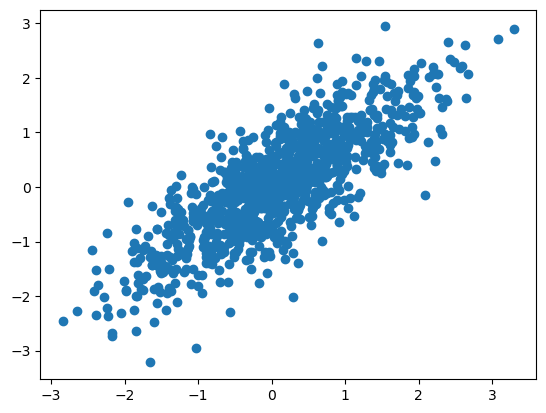

In [3]:
# nb samples
n = 1000
# Define Data Generator: 1D conditional gaussian
data_gen = ConditionalGaussian1d()
# Samples from the joint distribution P(Theta,X) = P(X)*P(Theta|X)
samples_x, samples_theta = data_gen.get_joint_data(n=n)


# plot X-distribution
plt.scatter(samples_x[:, 0], samples_x[:, 1])
plt.show()


#### Result 1: Uniformity of the expected PIT-distribution

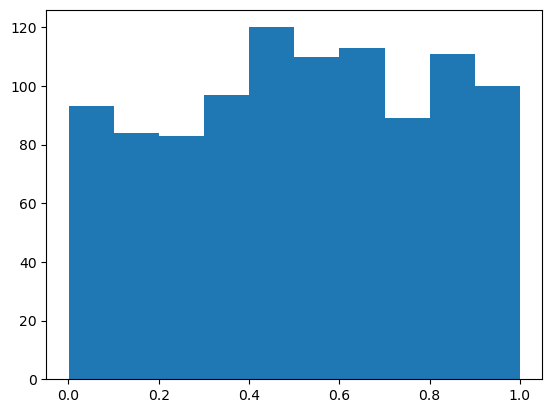

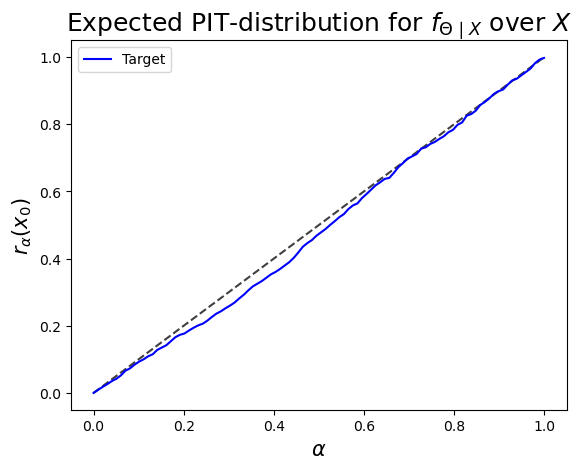

In [4]:
# PLOT EXPECTED PIT-DISTRIBUTION for the true distribution Theta|X

# Joint PIT-values [PIT(Theta_i, X_i, f_{Theta|X})]
true_joint_pit_values = data_gen.true_pit_values(samples_theta, samples_x)

# Plot histogram of expected PIT-distribution
plt.hist(true_joint_pit_values)
plt.show()

# PP-plot of expected PIT-distribution
PP_plot_1D(
    PIT_values=[true_joint_pit_values],
    alphas=ALPHAS,
    title=r"Expected PIT-distribution for $f_{\Theta \mid X}$ over $X$",
)


#### Result 2: Uniformity of globally non-consistent estimators
We consider two NF-estimators:
- good MAF: trained on the full context variable $X=(X_1, X_2)$
- bad MAF: trained on a non-sufficient context $g(X)=X_1$

In [5]:
# Get train, val and test samples:
# - train samples are used to train the flow,
# - cal samples are used to learn the (unknown) PIT-distributions
# - test samples are used to evaluate the known and learned PIT-distributions 

# Split in train/test sets 
train_size = 10_000  
cal_size = 5_000  
test_size = 1_000  

filename = 'saved_experiments/Gaussian1d_localPIT/datasets.pkl'
if os.path.exists(filename):
    dataset = torch.load(filename)
    x_train, theta_train = dataset['train']
    x_cal, theta_cal = dataset['cal']
    x_test, theta_test = dataset['test']
else:
    x_train, theta_train = data_gen.get_joint_data(n=train_size)
    x_cal, theta_cal = data_gen.get_joint_data(n=cal_size)
    x_test, theta_test = data_gen.get_joint_data(n=test_size)
    dataset = {'train': [x_train, theta_train], 'cal': [x_cal, theta_cal], 'test': [x_test, theta_test]}
    torch.save(dataset, filename)

print("NB training samples: ", x_train.shape)
print("NB calibration samples: ", x_cal.shape)
print("NB test samples: ", x_test.shape)


NB training samples:  torch.Size([10000, 2])
NB calibration samples:  torch.Size([5000, 2])
NB test samples:  torch.Size([1000, 2])


In [6]:
# TRAIN FLOWS

# Good MAF...
maf_good = construct_maf(
    theta_train, hidden_features=50, context_features=2, standardize_transform=True, num_layers=5
)

# ... trained on X=(X_1,X_2)
filename = 'saved_experiments/Gaussian1d_localPIT/maf_good.pkl'
if os.path.exists(filename):
    maf_good = torch.load(filename)
else:
    _, _ = train(
        maf_good,
        theta_train,
        context=x_train,  # X=(X_1,X_2)
        num_epochs=2000,
        batch_size=10,
        lr=0.005,
        validation=True,
        plot=False,
        epochs_until_converge=20,
    )

# Bad MAF...
maf_bad = construct_maf(
    theta_train, hidden_features=50, context_features=1, standardize_transform=True, num_layers=5
)

# trained on g(X)=(X_1)
g = first_dim_only
filename = 'saved_experiments/Gaussian1d_localPIT/maf_bad.pkl'
if os.path.exists(filename):
    maf_bad = torch.load(filename)
else:
    _, _ = train(
        maf_bad,
        theta_train,
        context=g(x_train),  # g(X)=(X_1)
        num_epochs=2000,
        batch_size=10,
        lr=0.005,
        validation=True,
        plot=False,
        epochs_until_converge=20,
    )

torch.save(maf_good, 'saved_experiments/Gaussian1d_localPIT/maf_good_layers10.pkl')
torch.save(maf_bad, 'saved_experiments/Gaussian1d_localPIT/maf_bad_layers10.pkl')

##### Global Consistency

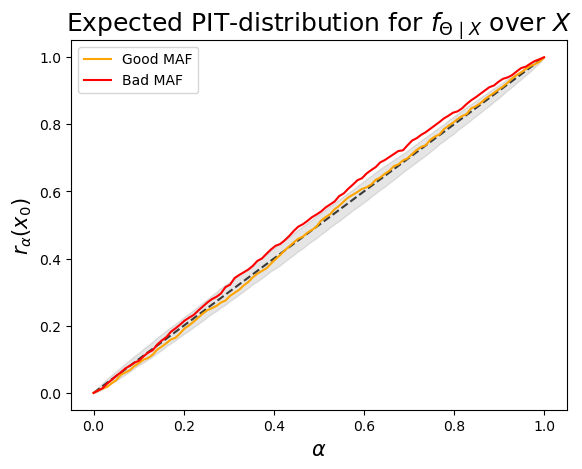

In [7]:
# PLOT EXPECTED PIT-DISTRIBUTION of the trained estimators

# Compute PIT-values of the flows F_{Q|X_i}(Theta_i)
# [PIT(Theta_i, X_i, maf_good) = F_{Q_good|X_i}(Theta_i)]
flow_joint_pit_values_good = cde_pit_values(
    theta_test, x_test, maf_good, feature_transform=identity
)
# [PIT(Theta_i, X_i, maf_bad) = F_{Q_bad|X_i}(Theta_i)]
flow_joint_pit_values_bad = cde_pit_values(

    theta_test, x_test, maf_bad, feature_transform=first_dim_only
)

# PP-plot of expected PIT-distribution for both flows
# alpha-quantiles = [P_X,Theta(Z < alpha)]
PP_plot_1D(
    PIT_values=[flow_joint_pit_values_good, flow_joint_pit_values_bad],
    alphas=ALPHAS,
    colors=["orange", "red"],
    labels=["Good MAF", "Bad MAF"],
    title=r"Expected PIT-distribution for $f_{\Theta \mid X}$ over $X$",
    confidence_int=True,
)


Both estimators have uniform PIT-distribution, but the bad MAF is not globally consistent. 

Indeed, the code below will show that the bad MAF is locally inconsistent, which implies also that it cannot be globally consistent.

##### Local Consistency

/data/parietal/store/work/jlinhart/git_repos/valDiags_flows/plot.py:12: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1648016052946/work/aten/src/ATen/native/RangeFactories.cpp:20.)
  eval_x = torch.linspace(x_i, x_f).reshape(-1, 1)


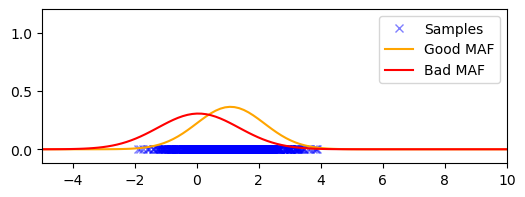

In [8]:
# Samples from the conditional distribution Theta|X=x_0
x_0 = torch.FloatTensor([[0, 1]])

samples_theta_x = torch.FloatTensor(
    [data_gen.sample_theta(x_0) for i in range(len(x_test))]
).reshape(-1, 1)

# Plot PDF of trained flows evaluated in x_0
flows = {"Good MAF": (maf_good, x_0, "orange"), "Bad MAF": (maf_bad, x_0[:, 0], "red")}
plot_pdf_1D(samples_theta_x, x_i=-5, x_f=10, flows=flows)


We can already see that the two flows disagree. Espcially in the variance. 

This was not represented in the global pp-plot, but can be visualized via the local pp-plot (see code below).

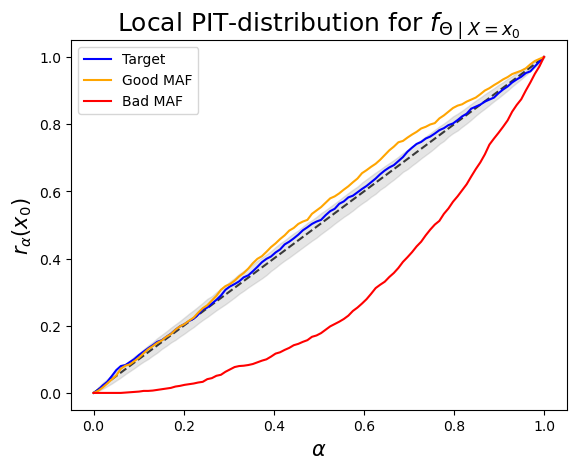

In [9]:
# Local PIT-distribution on samples Theta_i from Theta|X=x_0

# Compute PIT-values [PIT(Theta_i, X=x_0, f_true/good/bad) = F_{Q|X_i}(Theta_i)]
true_local_pit_values = data_gen.true_pit_values(samples_theta_x, x_0, local=True)
flow_local_pit_values_good = cde_pit_values(
    samples_theta_x, x_0, flow=maf_good, feature_transform=identity, local=True
)
flow_local_pit_values_bad = cde_pit_values(
    samples_theta_x, x_0, flow=maf_bad, feature_transform=first_dim_only, local=True
)

# PP-plot of the local distribution
# alpha-quantiles = [P_{Theta|X}(Z < alpha)]
PP_plot_1D(
    PIT_values=[
        true_local_pit_values,
        flow_local_pit_values_good,
        flow_local_pit_values_bad,
    ],
    alphas=ALPHAS,
    colors=["blue", "orange", "red"],
    labels=["Target", "Good MAF", "Bad MAF"],
    title=r"Local PIT-distribution for $f_{\Theta \mid X=x_0}$",
    confidence_int=True,
)


Indeed, the variance distorsion of the bad MAF is clearly visible in this pp-plot (red line in S-shape). 

This shows that if our function $g(X)$ doas not caracterize covariate relations between the elements of $X$ (e.g. non-sufficient summary statistics), the expected PIT-distribution will not show us the error, whereas the local PIT-distribution does.

We need a way to claculate the local PIT-distribution! 

## Estimating the Local PIT-Distribution

We define the $\alpha$-quantile of the local PIT-distribution as follows:

$$ r_{\alpha}(X) = \mathbb{P}_{\Theta \mid X}(\text{PIT}(\Theta, X ; f_{Q\mid X}) \leq \alpha) = \mathbb{E}[\mathbb{1}_{\{\text{PIT}(\Theta, X ; f_{Q\mid X}) \leq \alpha\}}\mid X]$$

### Method 1 proposed by [[Zhao et. al, UAI 2021]](https://arxiv.org/abs/2102.10473): 
**Regression of $W^{\alpha} = \mathbb{1}_{\{\text{PIT}(\Theta, X ; f_{Q\mid X}) \leq \alpha\}}$ on $X$, using samples from the joint $(\Theta_i, X_i) \sim f_{\Theta, X}$.**

The goal is to estimate the random variable $W^{\alpha}$ as a function $f$ of $X$. 

Theoretically, the optimal solution of this regression problem - in terms of $L^2$-distance $E\left[(W^{\alpha} - f(X))^2\right]$ - is the conditional expectation $f^{\star}(X) = \mathbb{E}[W^{\alpha} \mid X] = r_{\alpha}(X)$ (it corresponds to the othogonal projection of $W^{\alpha}$ on $L^2(\Omega, \mathcal{F}(X), \mathbb{P}) = L^2_X$).

#### Algorithm:
1. pre-compute $W^{\alpha}_i$ using the avalable samples $\Theta_i, X_i$
2. regress $W^{\alpha}_i$ on $X_i$ to get an estimate of $r_{\alpha}(X)$
3. evaluate $r_{\alpha}$ in $X=x_0$
4. plot $r_{\alpha}(x_0)$ as a function of $\alpha$ and compare to identity

#### Comments
- This is actually a binary classifiacation problem 
- We need to use a regressor / classifier that has an optimum defined by the conditional expectation! Different loss function (i.e. classifiers) can be used (cf. [On Loss Functions Which Minimii to Conditional Expected Values and Posterior Probabilities](https://authors.library.caltech.edu/93850/1/00243457.pdf)). Here they use `sklearn.MLPClassifier` trained with a log-loss (compatible).
- There is a monotonic coupling / ordering between $r_{\alpha}(X)$ and $\alpha$: $r_{\alpha}(X) \nearrow \alpha$
    - cf. [isotonic regression with monotonic constraint in sklearn](https://scikit-learn.org/stable/modules/isotonic.html) (//calibration with binary target variable)
    - what about the multivariate case? cf. Random Forest for multi-output with monotonic splitting criteria?
    - implement existing method and analyse if monotonic or not in $\alpha$


#### Implementation of the Regression Method from [[Zhao et. al, UAI 2021]](https://arxiv.org/abs/2102.10473):

In [10]:
# Training set for regression task: Samples from the joint !
# test set used for empirical approximations earlier
theta_train_PIT = theta_test
x_train_PIT = x_test

# PIT-values [PIT(Theta_i, X_i, flow)] used to compute labels 
pit_values_train_good = flow_joint_pit_values_good.ravel()
pit_values_train_bad = flow_joint_pit_values_bad.ravel()

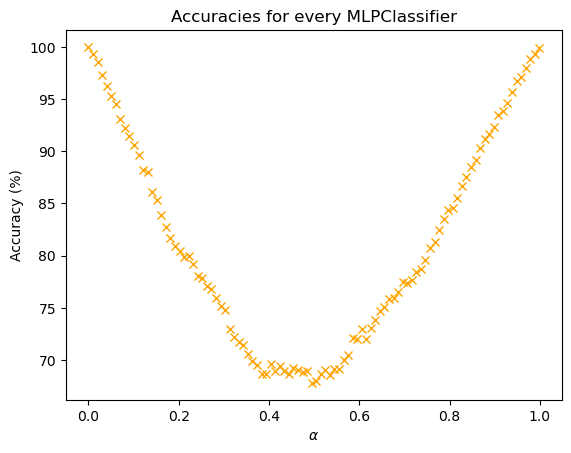

Mean training accuracy:  80.989


In [12]:
# Estimate local PIT-distribution quantiles for bad MAF
# Train several classifiers for each alpha value 
alphas = ALPHAS
pit_values_train = pit_values_train_bad
clfs = localPIT_regression_baseline(
    alphas=alphas, 
    pit_values_train=pit_values_train, # pit-values used to compute the targets
    x_train=x_train_PIT,
)
accuracies = {}
for alpha in alphas:
    W_a_train = (pit_values_train <= alpha).astype(int)  # compute the targets
    accuracies[alpha] = clfs[alpha].score(x_train_PIT, W_a_train) * 100

# Plot accuracies as a function of alpha
accuracies = pd.Series(accuracies)
accuracies.plot(style="x", color="orange")
plt.title(r"Accuracies for every MLPClassifier")
plt.xlabel(r"$\alpha$")
plt.ylabel("Accuracy (%)")
plt.show()
print("Mean training accuracy: ", np.round(np.mean(accuracies), 3))

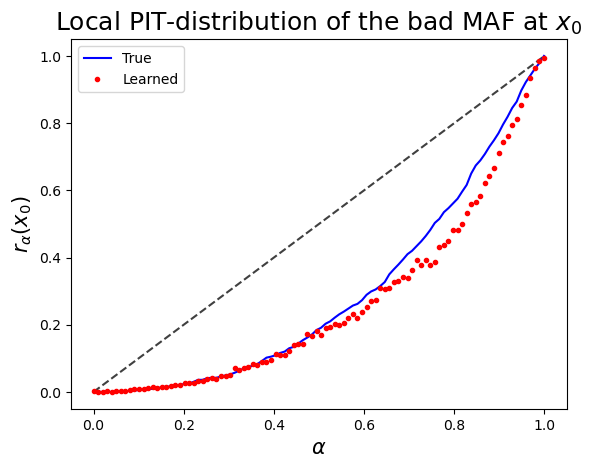

Euclidean Distance to empirical local pit-distribution (ground-truth):  0.439
Euclidean Distance to identity (normalized):  0.455
Mean training accuracy:  80.989
Monotonicity: 76.77% of the points agree with: 'the alpha-quantile has to be increasing with alpha'.


In [13]:
# Local PP-plot

# estimate local pit values at x_0 for every alpha
r_alpha_test = infer_r_alphas_baseline(x_0, clfs)
r_alpha_test = pd.Series(r_alpha_test)

PP_plot_1D(
    PIT_values=[flow_local_pit_values_bad],
    alphas=alphas,
    r_alpha_learned = [r_alpha_test],
    colors=["blue"],
    colors_r_alpha = ["red"],
    labels=["True"],
    title=r"Local PIT-distribution of the bad MAF at $x_0$",
)

# Evaluation metrics
z_maf_bad_x = PP_vals(flow_local_pit_values_bad, alphas)
euc_dist_to_gt = math.dist(z_maf_bad_x, np.array(r_alpha_test))
euc_dist_to_id = math.dist(alphas, np.array(r_alpha_test))
max = [0]*len(alphas)
max[-1]=1
max_dist = math.dist(alphas, max)
euc_dist_to_id_norm = euc_dist_to_id/max_dist

print(
    "Euclidean Distance to empirical local pit-distribution (ground-truth): ",
    np.round(euc_dist_to_gt, 3),
)
print(
    "Euclidean Distance to identity (normalized): ",
    np.round(euc_dist_to_id_norm, 3),
)
print("Mean training accuracy: ", np.round(np.mean(accuracies), 3))

# Check monotonicity of r_alpha
monotonicity = np.mean(np.diff(np.array(r_alpha_test)) >= 0)
print(
    f"Monotonicity: {np.round(monotonicity*100,2)}% of the points agree with: 'the alpha-quantile has to be increasing with alpha'."
)


Errors:
- logisticregressor doesnt work because needs 2 classes in training data. 
- Isotonic regression doesn't work because 'input X should be a 1d array or 2d array with 1 feature'. Anyway it should be increasing with alpha and not x.
- if including 1 in the alphas list, we get an outlier in the prediction

Comments:
- MLP trained for classification with the `log_loss`: $L_{\log }(y, p)=-(y \log (p)+(1-y) \log (1-p))$
- $p=$`predict_proba[:,1]` gives the probability of the **class $1$**, the success class of being $\leq \alpha$
- The classifiers are less accurate in the middle range, which is exactly what we expect: 
    - the goal is to plot the miscalibration of the probabilities, so it is normal that the accuracies drop for a miscalibrated problem: **Accuracy is not the right metric here!** 
    - cf. comparison to `Dummy` whose accuracy drops to $0.5$ at $\alpha = 0.5$ (linear function)


### Amortized in alpha 

**Idea: Only one Classifier on alpha and X:**
- can make relationship between r_alpha and alpha explicit and thus learn the monotonic constraint? 
- converges to what theoretically?

#### Method 2: 
Expand the training-set to take into account all ${\alpha_t}$ $\in$ `np.linspace(0,1,T)`:
- new targets: $W^{\alpha_t}_i$ for all $\alpha_t$ and $(\Theta_i, X_i)$
- new features **including $\alpha$**: $\{(X_0,\alpha_t), \dots, (X_n,\alpha_t)\}$ for all $\alpha_t$

The size is multiplied by the number $T$ of $\alpha$-values (here $T=101$)


In [16]:
# Estimate the local PIT
# Train the Classifier amortized on x and all alphas
clf_grid = localPIT_regression_grid(
    pit_values_train=pit_values_train_bad,
    x_train=x_train_PIT,
)


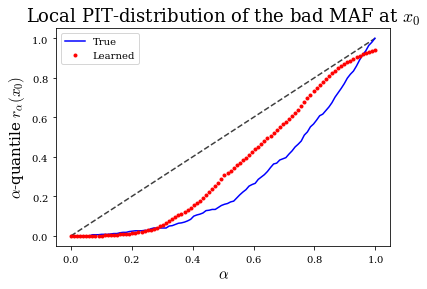

Euclidean Distance to empirical local pit-distribution (ground-truth):  1.082
Monotonicity: 100.0% of the points agree with: 'the alpha-quantile has to be increasing with alpha'.


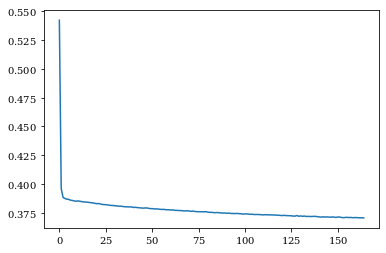

In [18]:
# Local PP-Plot

# Evaluate in x_0 and for all alphas
r_alpha_test_grid = infer_r_alphas_amortized(x_0, ALPHAS, clf_grid)
r_alpha_test_grid = pd.Series(r_alpha_test_grid)

PP_plot_1D(
    PIT_values=[flow_local_pit_values_bad],
    alphas=ALPHAS,
    r_alpha_learned=[r_alpha_test_grid],
    colors=["blue"],
    colors_r_alpha = ["red"],
    labels=["True"],
    title=r"Local PIT-distribution of the bad MAF at $x_0$",
)

# Evaluation metrics
z_maf_bad_x = PP_vals(flow_local_pit_values_bad, ALPHAS)
euc_dist_to_gt = math.dist(z_maf_bad_x, r_alpha_test_grid)
print(
    "Euclidean Distance to empirical local pit-distribution (ground-truth): ",
    np.round(euc_dist_to_gt, 3),
)

# Check monotonicity of r_alpha
monotonicity = np.mean(np.diff(r_alpha_test_grid) >= 0)
print(
    f"Monotonicity: {monotonicity*100}% of the points agree with: 'the alpha-quantile has to be increasing with alpha'."
)

# Plot loss evolution
plt.plot(clf_grid.loss_curve_)
plt.show()

In [19]:
from sklearn.ensemble import HistGradientBoostingClassifier
clf_hist = HistGradientBoostingClassifier(monotonic_cst=[0, 0, 1], max_iter=70)


clf_grid_hist = localPIT_regression_grid(
    pit_values_train=pit_values_train_bad,
    x_train=x_train_PIT,
    classifier=clf_hist
)

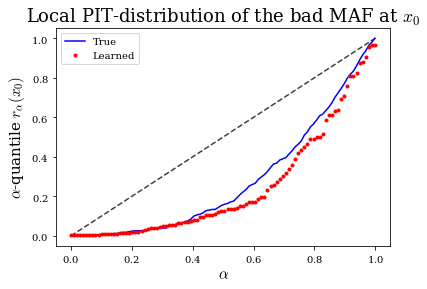

Euclidean Distance to empirical local pit-distribution (ground-truth):  0.493
Monotonicity: 100.0% of the points agree with: 'the alpha-quantile has to be increasing with alpha'.


In [22]:
# Local PP-Plot
r_alpha_test_hist_grid = infer_r_alphas_amortized(x_0, ALPHAS, clf_grid_hist)
r_alpha_test_hist_grid = pd.Series(r_alpha_test_hist_grid)

PP_plot_1D(
    PIT_values=[flow_local_pit_values_bad],
    alphas=ALPHAS,
    r_alpha_learned=[r_alpha_test_hist_grid],
    colors=["blue"],
    colors_r_alpha = ["red"],
    labels=["True"],
    title=r"Local PIT-distribution of the bad MAF at $x_0$",
)

# Evaluation metrics
z_maf_bad_x = PP_vals(flow_local_pit_values_bad, ALPHAS)
euc_dist_to_gt = math.dist(z_maf_bad_x, r_alpha_test_hist_grid)
print(
    "Euclidean Distance to empirical local pit-distribution (ground-truth): ",
    np.round(euc_dist_to_gt, 3),
)

# Check monotonicity of r_alpha
monotonicity = np.mean(np.diff(r_alpha_test_hist_grid) >= 0)
print(
    f"Monotonicity: {monotonicity*100}% of the points agree with: 'the alpha-quantile has to be increasing with alpha'."
)

#### Method 3:
Sample $\alpha \sim \mathcal{U}(0,1) $ $T=1$ time for each sample $(\Theta_i, X_i)$ of the joint. 

In [23]:
# Train the Classifier amortized on x and 1 sampled alpha

clf_sample = localPIT_regression_sample(
    pit_values_train=pit_values_train_bad,
    x_train=x_train_PIT,
    nb_samples=1,
)



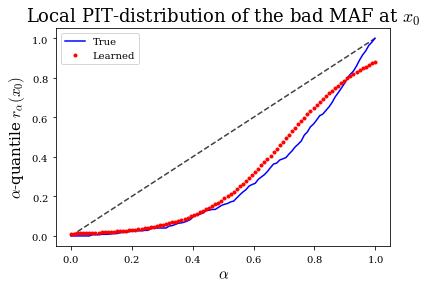

Euclidean Distance to empirical local pit-distribution (ground-truth):  0.493
Monotonicity: 100.0% of the points agree with: 'the alpha-quantile has to be increasing with alpha'.


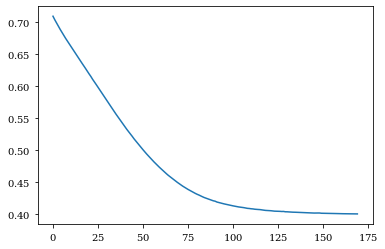

In [24]:
# Local PP-Plot

# Evaluate in x_0 and for all alphas
r_alpha_test_sample = infer_r_alphas_amortized(x_0, ALPHAS, clf_sample)
r_alpha_test_sample = pd.Series(r_alpha_test_sample)
PP_plot_1D(
    PIT_values=[flow_local_pit_values_bad],
    alphas=ALPHAS,
    r_alpha_learned = [r_alpha_test_sample],
    colors=["blue"],
    colors_r_alpha = ["red"],
    labels=["True"],
    title=r"Local PIT-distribution of the bad MAF at $x_0$",
)

# Evaluation metrics
z_maf_bad_x = PP_vals(flow_local_pit_values_bad, ALPHAS)
euc_dist_to_gt = math.dist(z_maf_bad_x, r_alpha_test_sample)
print(
    "Euclidean Distance to empirical local pit-distribution (ground-truth): ",
    np.round(euc_dist_to_gt, 3),
)

# Check monotonicity of r_alpha
monotonicity = np.mean(np.diff(r_alpha_test_sample) >= 0)
print(
    f"Monotonicity: {monotonicity*100}% of the points agree with: 'the alpha-quantile has to be increasing with alpha'."
)

# Plot loss evolution
plt.plot(clf_sample.loss_curve_)
plt.show()


**Comments:**

- The original method needs multiple classifiers (one for each alpha value) is not verifying the monotonic constraint. 
- The in alpha amortized versions insure that the monotonic constrain is respected. BUT depending on the $x_0$ used for evaluation, the amortized versions can be pretty far from the black groundtruth (euclidean distance). 
- We could increase $T$ for method 3 (e.g. $T=20$).
- Accuracy is not the right metric! 
- We should compare the results in one plot: distance to GT (black curve), computational time, number of training samples needed (alpha samples during training and features...)

**TODO:**
- Evaluate the variance of the methods over several trainings of a model evaluated in the same $x_0$ (model uncertainty)
- Evaluate the variance of the methods over several choices of $x_0$ (data uncertainty)
- Plots to visualize comparisons between methods:
    - distance to ground-truth
    - computational cost
    - number of training samples needed
    
Small checks:
- Compare to `LogisticRegression`
- See convergence criteria of `MLPClassifier`
- confidence intervals like in paper code? 
- add constraint (bounds (0,1)?)
- regularize?




In [26]:
# Train the Classifier amortized on x and multiple sampled alpha

clf_sample_T = localPIT_regression_sample(
    pit_values_train=pit_values_train_bad,
    x_train=x_train_PIT,
    nb_samples=50,
)


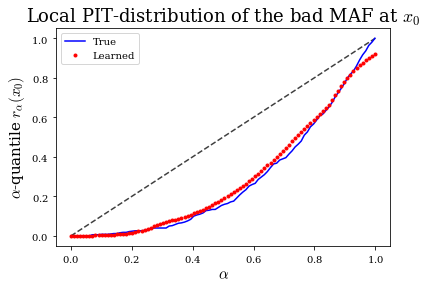

Euclidean Distance to empirical local pit-distribution (ground-truth):  0.269
Monotonicity: 100.0% of the points agree with: 'the alpha-quantile has to be increasing with alpha'.


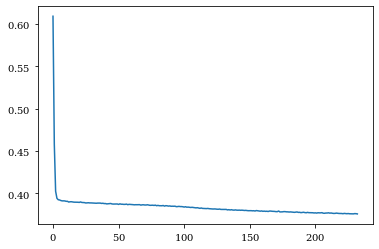

In [27]:
# Local PP-Plot
# Evaluate in x_0 and for all alphas
r_alpha_test_sample_T = infer_r_alphas_amortized(x_0, ALPHAS, clf_sample_T)
r_alpha_test_sample_T = pd.Series(r_alpha_test_sample_T)

PP_plot_1D(
    PIT_values=[flow_local_pit_values_bad],
    alphas=ALPHAS,
    r_alpha_learned = [r_alpha_test_sample_T],
    colors=["blue"],
    colors_r_alpha = ["red"],
    labels=["True"],
    title=r"Local PIT-distribution of the bad MAF at $x_0$",
)

# Evaluation metrics
z_maf_bad_x = PP_vals(flow_local_pit_values_bad, ALPHAS)
euc_dist_to_gt = math.dist(z_maf_bad_x, r_alpha_test_sample_T)
print(
    "Euclidean Distance to empirical local pit-distribution (ground-truth): ",
    np.round(euc_dist_to_gt, 3),
)

# Check monotonicity of r_alpha
monotonicity = np.mean(np.diff(r_alpha_test_sample_T) >= 0)
print(
    f"Monotonicity: {monotonicity*100}% of the points agree with: 'the alpha-quantile has to be increasing with alpha'."
)

# Plot loss evolution
plt.plot(clf_sample_T.loss_curve_)
plt.show()


### Compare Local PIT Regression Methods

In [27]:
from diagnostics.uni_local_test_scripts import run_localPIT_regression

#### Show that for grid and sample methods 500 samples are not enough 


In [14]:
# 500 samples

from functools import partial
mlp_sample_1 = partial(localPIT_regression_sample, nb_samples=1)
mlp_sample_50 = partial(localPIT_regression_sample, nb_samples=50)

methods = [
    localPIT_regression_baseline,
    localPIT_regression_grid,
    mlp_sample_1,
    mlp_sample_50
]

method_names = ['baseline', 'grid', 'sample 1', 'sample 50']

x_evals = [
    torch.FloatTensor([[0, 0]]),
    torch.FloatTensor([[0, 1]]),
    # torch.FloatTensor([[0, -1]]),
    # torch.FloatTensor([[1, 0]]),
    torch.FloatTensor([[-1, 1]]),
]

r_alpha_learned, labels, true_pit_values_bad, x_samples_train, _ = run_localPIT_regression(
    methods,
    method_names,
    x_evals,
    nb_train_samples=500,
    joint_data_generator=data_gen.get_joint_data,
    flow=maf_bad,
    feature_transform=first_dim_only,
    samples_train=(x_train_PIT, theta_train_PIT)
)

r_alpha_learned_good, _, true_pit_values_good, _, _ = run_localPIT_regression(
    methods,
    method_names,
    x_evals,
    nb_train_samples=500,
    joint_data_generator=data_gen.get_joint_data,
    flow=maf_good,
    feature_transform=identity,
    samples_train=x_samples_train,
)

NULL HYP:  False
x_eval 0:  tensor([[0., 0.]])
baseline
grid
sample 1
sample 50
x_eval 1:  tensor([[0., 1.]])
baseline
grid
sample 1
sample 50
x_eval 2:  tensor([[-1.,  1.]])
baseline
grid
sample 1
sample 50
NULL HYP:  False
x_eval 0:  tensor([[0., 0.]])
baseline
grid
sample 1
sample 50
x_eval 1:  tensor([[0., 1.]])
baseline
grid
sample 1
sample 50
x_eval 2:  tensor([[-1.,  1.]])
baseline
grid
sample 1
sample 50


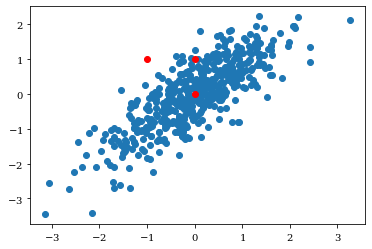

In [15]:
# plot x_eval 
x_train_PIT_new, _ = x_samples_train
plt.scatter(x_train_PIT_new[:,0], x_train_PIT_new[:,1])
x_evals = torch.stack(x_evals, axis=0)[:,0]
plt.scatter(x_evals[:,0], x_evals[:,1], color='red')

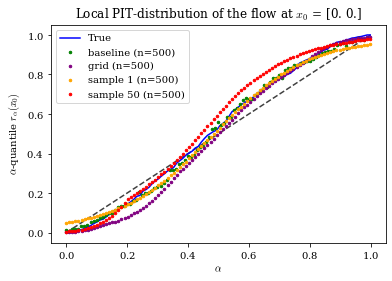

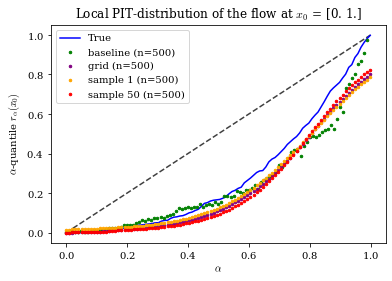

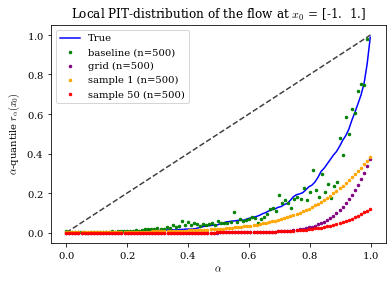

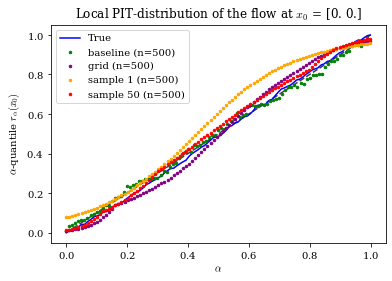

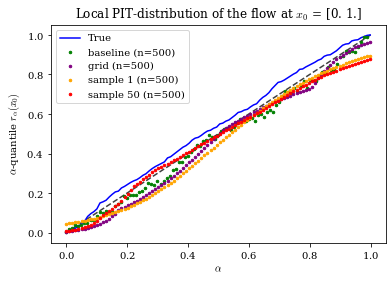

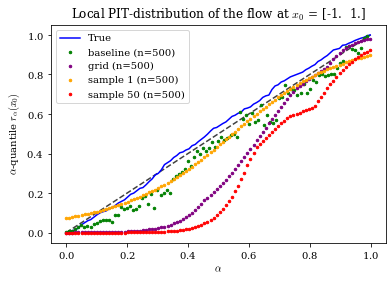

In [16]:
# show that for grid and sample methods 500 samples are not enough 

# bad maf
compare_pp_plots_regression(
    r_alpha_learned,
    true_pit_values_bad,
    x_evals,
    nb_train_samples=500,
    labels=labels,
)

# good maf
compare_pp_plots_regression(
    r_alpha_learned_good,
    true_pit_values_good,
    x_evals,
    nb_train_samples=500,
    labels=labels,
)

#### Show that x_eval needs to be in training data distribution

In [22]:
# 5000 samples

from functools import partial
mlp_sample_1 = partial(localPIT_regression_sample, nb_samples=1)
mlp_sample_50 = partial(localPIT_regression_sample, nb_samples=50)

methods = [
    localPIT_regression_baseline,
    localPIT_regression_grid,
    mlp_sample_1,
    mlp_sample_50
]

method_names = ['baseline', 'grid', 'sample 1', 'sample 50']

x_evals = [
    torch.FloatTensor([[0, 0]]),
    torch.FloatTensor([[0, 1]]),
    # torch.FloatTensor([[0, -1]]),
    # torch.FloatTensor([[1, 0]]),
    torch.FloatTensor([[-1, 1]]),
]

r_alpha_learned, labels, true_pit_values_bad, x_samples_train, _ = run_localPIT_regression(
    methods,
    method_names,
    x_evals,
    nb_train_samples=5000,
    joint_data_generator=data_gen.get_joint_data,
    flow=maf_bad,
    feature_transform=first_dim_only,
)

r_alpha_learned_good, _, true_pit_values_good, _, _ = run_localPIT_regression(
    methods,
    method_names,
    x_evals,
    nb_train_samples=5000,
    joint_data_generator=data_gen.get_joint_data,
    flow=maf_good,
    feature_transform=identity,
    samples_train=x_samples_train,
)

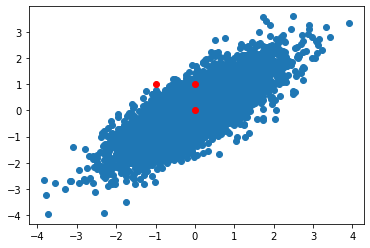

In [23]:
# plot x_eval 
x_train_PIT_new, _ = x_samples_train
plt.scatter(x_train_PIT_new[:,0], x_train_PIT_new[:,1])
x_evals = torch.stack(x_evals, axis=0)[:,0]
plt.scatter(x_evals[:,0], x_evals[:,1], color='red')

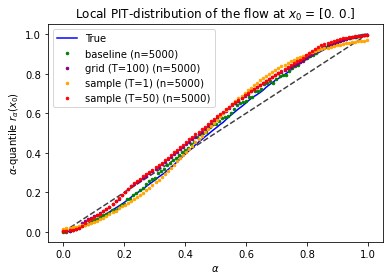

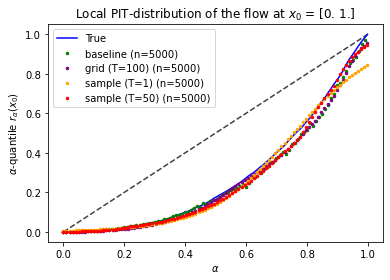

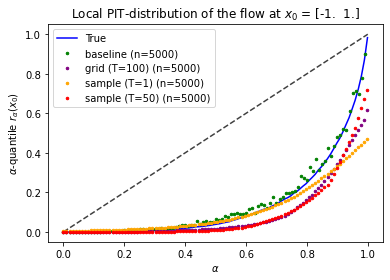

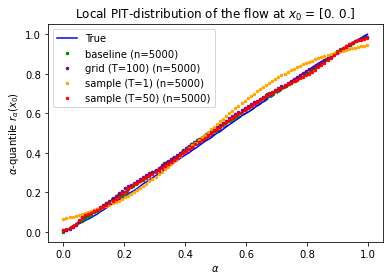

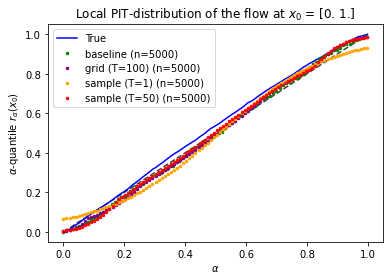

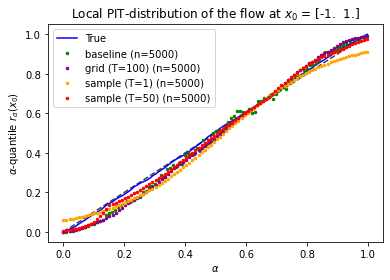

In [25]:
# show that x_eval needs to be in training data distribution

# bad maf
compare_pp_plots_regression(
    r_alpha_learned,
    true_pit_values_bad,
    x_evals,
    nb_train_samples=5000,
    labels=labels,
)

# good maf
compare_pp_plots_regression(
    r_alpha_learned_good,
    true_pit_values_good,
    x_evals,
    nb_train_samples=5000,
    labels=labels,
)

500 samples were not enough for the 'amortized in alpha'-methods
- more to learn
- not enough x samples for the amount of alphas used
- x_eval has to be in the distribution of the train set, no generalisation outside of this range.
- the baseline can concentrate on learning point-estimates for a given alpha and lots of x samples --> better generalization w.r.t. x 

I tried for 5000 samples to train the classifiers.
- all methods work 
- grid-method does not work if x_eval is not in the distribution of the train set. 
- Overfit of grid-method, no generalisation outside of this range.

**PROBLEM:** to estimate the local PIT-distribution we need a ML algorithm that also requires summry statistics on X.

## Improving the Regressor using `HistGradientBoostingClassifier` with monotonic constraint on only the `alpha` variable

In [17]:
from sklearn.ensemble import HistGradientBoostingClassifier
from functools import partial

clf = HistGradientBoostingClassifier(monotonic_cst=[0, 0, 1], max_iter=70)

hist_reg_grid = partial(localPIT_regression_grid, classifier=clf)
hist_reg_sample_1 = partial(localPIT_regression_sample, classifier=clf, nb_samples=1)
hist_reg_sample_50 = partial(localPIT_regression_sample, classifier=clf, nb_samples=50)


In [18]:
# 500 samples

methods = [
    localPIT_regression_baseline,
    hist_reg_grid,
    hist_reg_sample_1,
    hist_reg_sample_50
]

method_names = ['baseline', 'grid_hist', 'sample_1_hist', 'sample_50_hist']

x_evals = [
    torch.FloatTensor([[0, 0]]),
    torch.FloatTensor([[0, 1]]),
    # torch.FloatTensor([[0, -1]]),
    # torch.FloatTensor([[1, 0]]),
    torch.FloatTensor([[-1, 1]]),
]

r_alpha_learned, labels, true_pit_values_bad, x_samples_train, _ = run_localPIT_regression(
    methods,
    method_names,
    x_evals,
    nb_train_samples=500,
    joint_data_generator=data_gen.get_joint_data,
    flow=maf_bad,
    feature_transform=first_dim_only,
    samples_train=(x_train_PIT, theta_train_PIT)
)

r_alpha_learned_good, _, true_pit_values_good, _, _ = run_localPIT_regression(
    methods,
    method_names,
    x_evals,
    nb_train_samples=500,
    joint_data_generator=data_gen.get_joint_data,
    flow=maf_good,
    feature_transform=identity,
    samples_train=x_samples_train,
    )
    

NULL HYP:  False
x_eval 0:  tensor([[0., 0.]])
baseline
grid_hist
sample_1_hist
sample_50_hist
x_eval 1:  tensor([[0., 1.]])
baseline
grid_hist
sample_1_hist
sample_50_hist
x_eval 2:  tensor([[-1.,  1.]])
baseline
grid_hist
sample_1_hist
sample_50_hist
NULL HYP:  False
x_eval 0:  tensor([[0., 0.]])
baseline
grid_hist
sample_1_hist
sample_50_hist
x_eval 1:  tensor([[0., 1.]])
baseline
grid_hist
sample_1_hist
sample_50_hist
x_eval 2:  tensor([[-1.,  1.]])
baseline
grid_hist
sample_1_hist
sample_50_hist


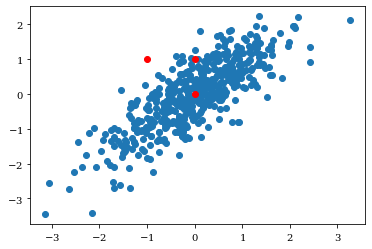

In [19]:
# plot x_eval 
x_train_PIT_new, _ = x_samples_train
plt.scatter(x_train_PIT_new[:,0], x_train_PIT_new[:,1])
x_evals = torch.stack(x_evals, axis=0)[:,0]
plt.scatter(x_evals[:,0], x_evals[:,1], color='red')

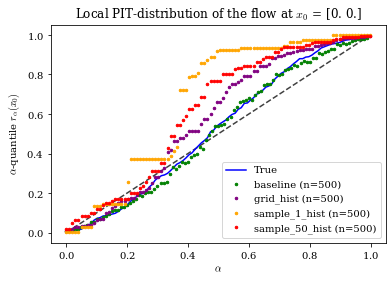

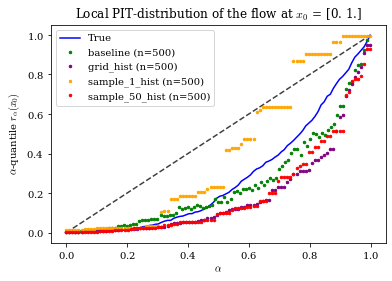

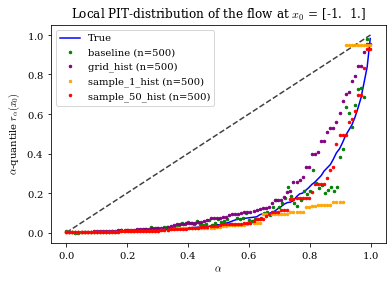

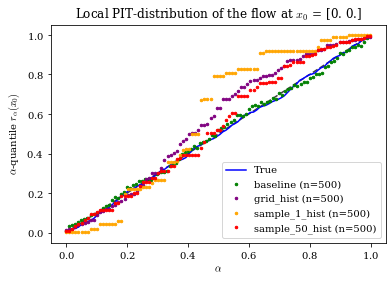

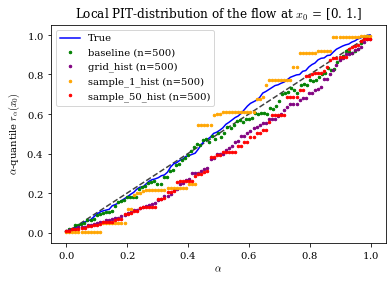

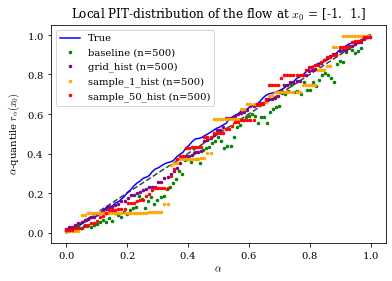

In [20]:
# show that for grid and sample methods 500 samples are not enough 

# bad maf
compare_pp_plots_regression(
    r_alpha_learned,
    true_pit_values_bad,
    x_evals,
    nb_train_samples=500,
    labels=labels,
)

# good maf
compare_pp_plots_regression(
    r_alpha_learned_good,
    true_pit_values_good,
    x_evals,
    nb_train_samples=500,
    labels=labels,
)

#### Show that x_eval needs to be in training data distribution

In [22]:
# 5000 samples

methods = [
    localPIT_regression_baseline,
    hist_reg_grid,
    hist_reg_sample_1,
    hist_reg_sample_50
]

method_names = ['baseline', 'grid_hist', 'sample_1_hist', 'sample_50_hist']

x_evals = [
    torch.FloatTensor([[0, 0]]),
    torch.FloatTensor([[0, 1]]),
    # torch.FloatTensor([[0, -1]]),
    # torch.FloatTensor([[1, 0]]),
    torch.FloatTensor([[-1, 1]]),
]

r_alpha_learned, labels, true_pit_values_bad, x_samples_train, _ = run_localPIT_regression(
    methods,
    method_names,
    x_evals,
    nb_train_samples=5000,
    joint_data_generator=data_gen.get_joint_data,
    flow=maf_bad,
    feature_transform=first_dim_only,
)

r_alpha_learned_good, _, true_pit_values_good, _, _ = run_localPIT_regression(
    methods,
    method_names,
    x_evals,
    nb_train_samples=5000,
    joint_data_generator=data_gen.get_joint_data,
    flow=maf_good,
    feature_transform=identity,
    samples_train=x_samples_train,
)

NULL HYP:  False
x_eval 0:  tensor([[0., 0.]])
baseline
grid_hist
sample_1_hist
sample_50_hist
x_eval 1:  tensor([[0., 1.]])
baseline
grid_hist
sample_1_hist
sample_50_hist
x_eval 2:  tensor([[-1.,  1.]])
baseline
grid_hist
sample_1_hist
sample_50_hist
NULL HYP:  False
x_eval 0:  tensor([[0., 0.]])
baseline
grid_hist
sample_1_hist
sample_50_hist
x_eval 1:  tensor([[0., 1.]])
baseline
grid_hist
sample_1_hist
sample_50_hist
x_eval 2:  tensor([[-1.,  1.]])
baseline
grid_hist
sample_1_hist
sample_50_hist


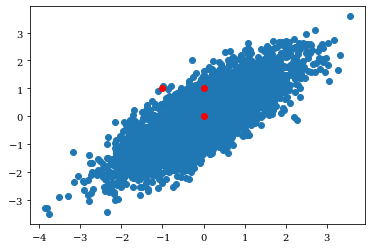

In [23]:
# plot x_eval 
x_train_PIT_new, _ = x_samples_train
plt.scatter(x_train_PIT_new[:,0], x_train_PIT_new[:,1])
x_evals = torch.stack(x_evals, axis=0)[:,0]
plt.scatter(x_evals[:,0], x_evals[:,1], color='red')

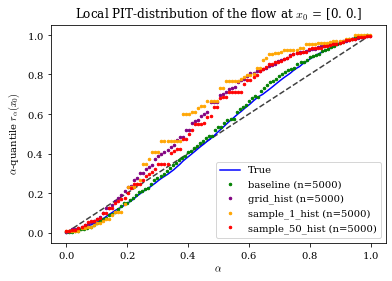

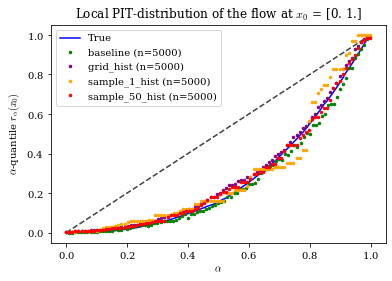

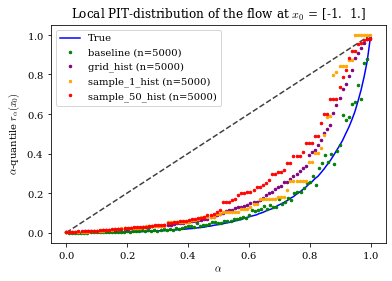

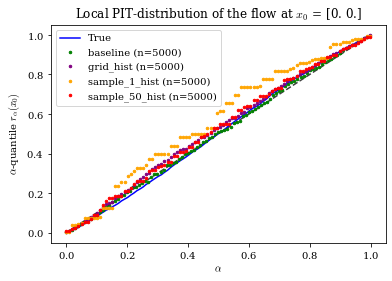

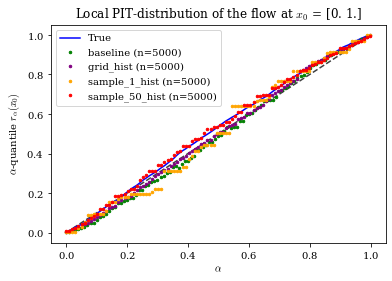

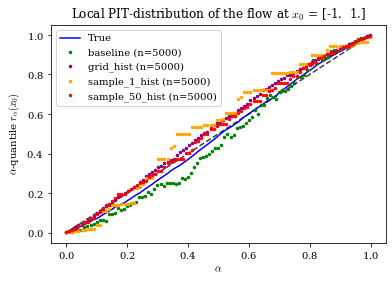

In [24]:
# show that x_eval needs to be in training data distribution

# bad maf
compare_pp_plots_regression(
    r_alpha_learned,
    true_pit_values_bad,
    x_evals,
    nb_train_samples=5000,
    labels=labels,
)

# good maf
compare_pp_plots_regression(
    r_alpha_learned_good,
    true_pit_values_good,
    x_evals,
    nb_train_samples=5000,
    labels=labels,
)

## Emprircal method comparison
Cross-val for gaussian with increasing mean and std shift

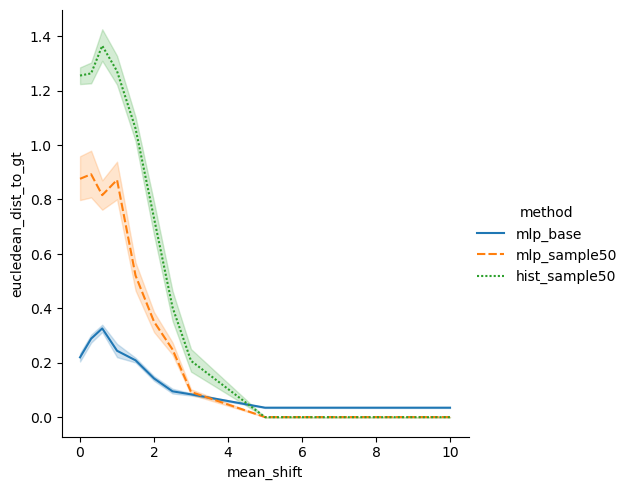

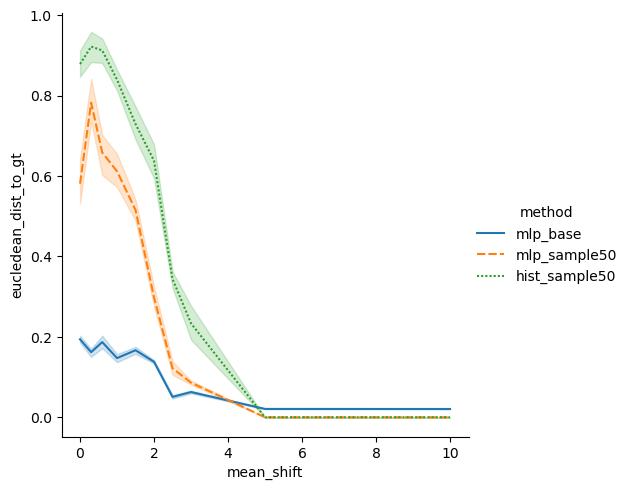

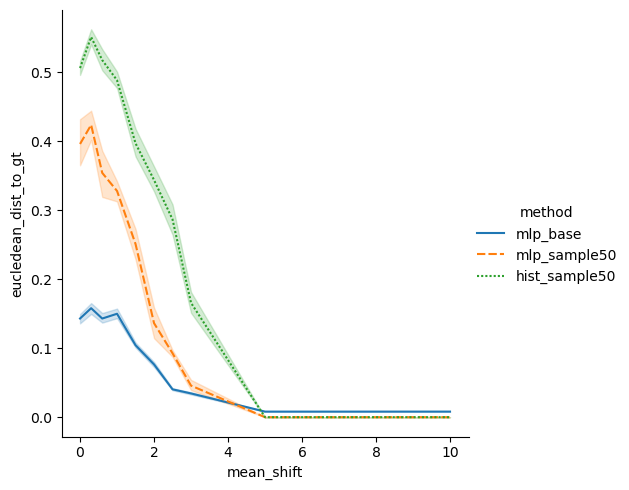

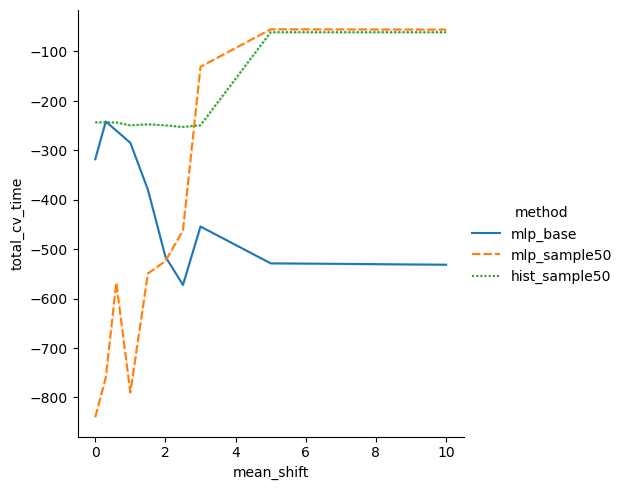

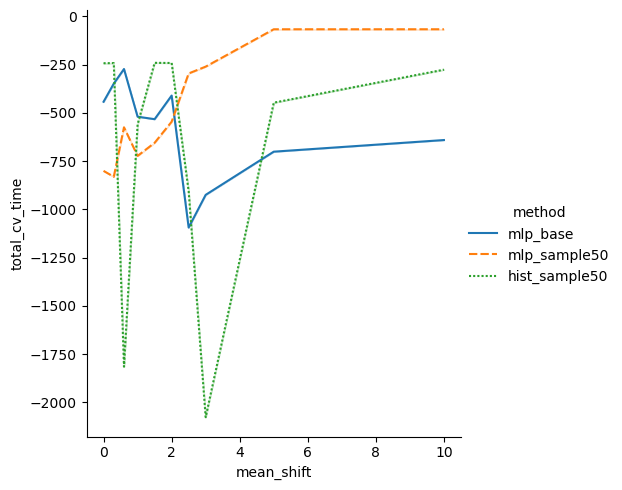

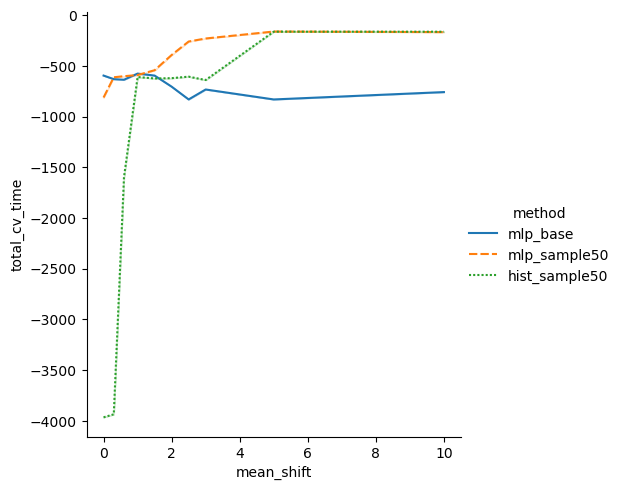

In [20]:
# n_trials = 10
N = [1000, 2000, 5000]
dfs_mean = {}
dfs_scale = {}
for n in N:
    dfs_mean[n] = torch.load(f'saved_experiments/Gaussian1d_localPIT/localPIT_eval_clfs/df_mean_{n}.pkl')
    dfs_scale[n] = torch.load(f'saved_experiments/Gaussian1d_localPIT/localPIT_eval_clfs/df_scale_{n}.pkl')


import seaborn as sns
for n in N:
    sns.relplot(
        data=dfs_mean[n], x="mean_shift", y="eucledean_dist_to_gt",
        hue="method", style="method", kind="line",
    )
    plt.show()

for n in N:
    sns.relplot(
        data=dfs_mean[n], x="mean_shift", y="total_cv_time",
        hue="method", style="method", kind="line",
    )
    plt.show()

# 

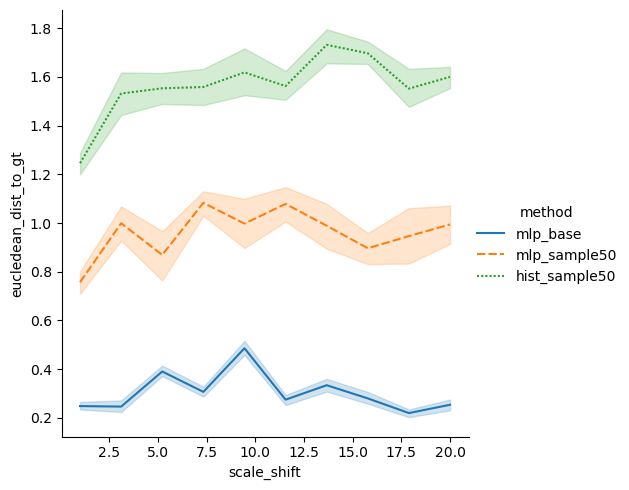

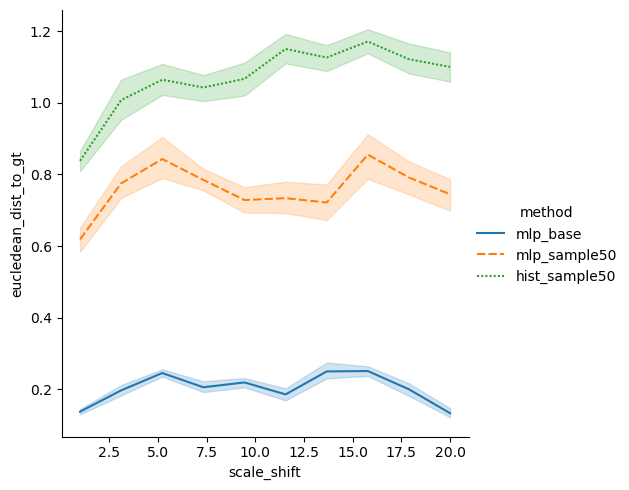

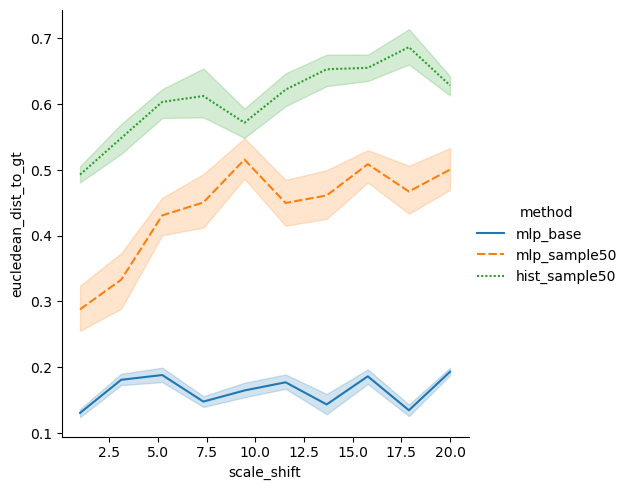

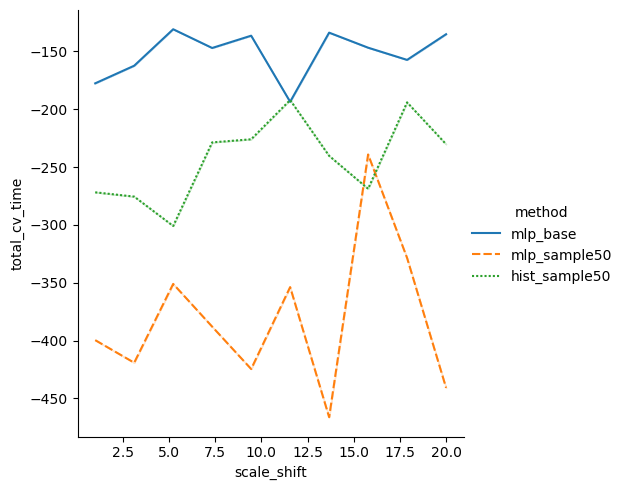

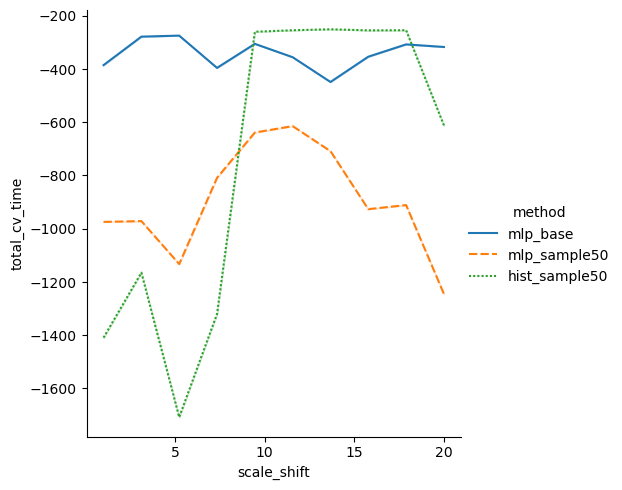

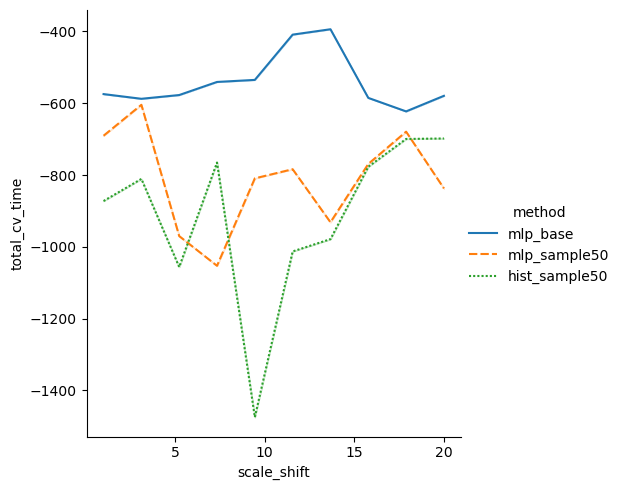

In [21]:
for n in N:
    sns.relplot(
        data=dfs_scale[n], x="scale_shift", y="eucledean_dist_to_gt",
        hue="method", style="method", kind="line",
    )
    plt.show()

for n in N:
    sns.relplot(
        data=dfs_scale[n], x="scale_shift", y="total_cv_time",
        hue="method", style="method", kind="line",
    )
    plt.show()


## New Local PIT estimation method: discrimator

In [10]:
from diagnostics.localPIT_regression import local_flow_c2st, eval_local_flow_c2st

flow_values_cal_good = maf_good._transform(theta_cal, context=x_cal)[0].detach().numpy()
flow_values_cal_bad = maf_bad._transform(theta_cal, context=first_dim_only(x_cal))[0].detach().numpy()

norm_samples = norm().rvs(cal_size)

### Global test 

In [16]:
# Global test with mlp
from sbi.utils.metrics import c2st_scores
scores_good = c2st_scores(torch.tensor(flow_values_cal_good), torch.tensor(norm_samples[:,None]), n_folds=10)
scores_bad = c2st_scores(torch.tensor(flow_values_cal_bad), torch.tensor(norm_samples[:,None]), n_folds=10)
print('good:', np.mean(scores_good).__round__(2), '+/-', np.std(scores_good).__round__(2))
print('bad:', np.mean(scores_bad).__round__(2), '+/-', np.std(scores_bad).__round__(2))

good: 0.5 +/- 0.02
bad: 0.52 +/- 0.02


### Local Test 

#### Classifier and calibration set size choice

In [18]:
# n_trials = 10
N = [1000, 2000, 5000]
dfs_mean = {}
dfs_scale = {}
for n in N:
    dfs_mean[n] = torch.load(f'saved_experiments/Gaussian1d_localPIT/lc2st_eval_clfs/df_mean_{n}.pkl')
    dfs_mean[n]['total_cv_time'] = dfs_mean[n]['total_cv_time']*-1
    dfs_scale[n] = torch.load(f'saved_experiments/Gaussian1d_localPIT/lc2st_eval_clfs/df_scale_{n}.pkl')
    dfs_scale[n]['total_cv_time'] = dfs_scale[n]['total_cv_time']*-1

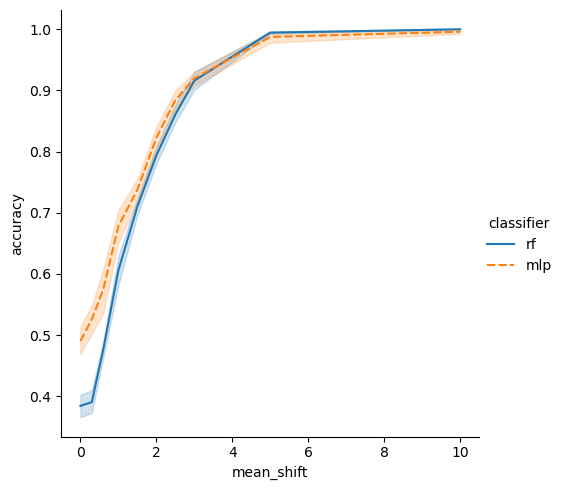

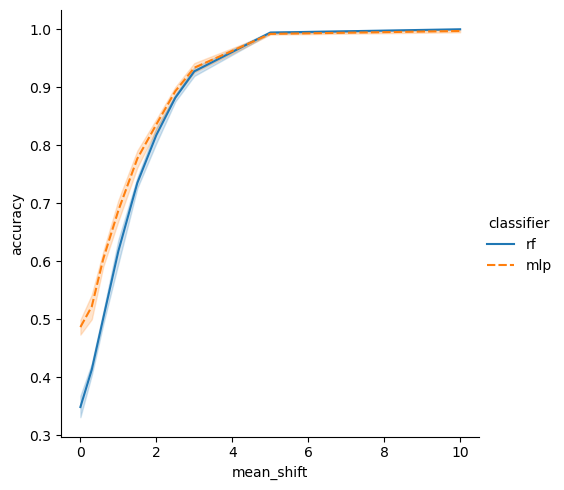

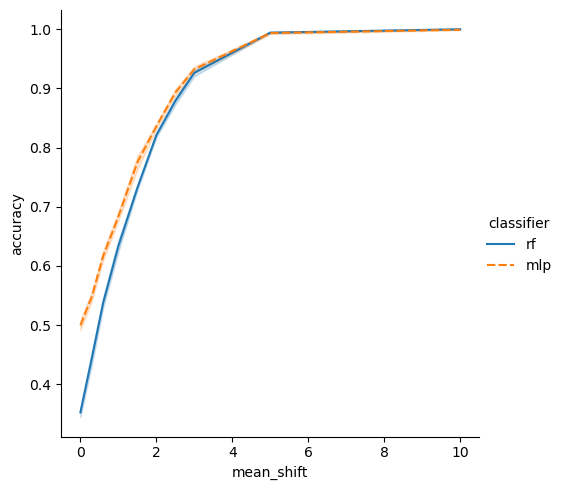

In [19]:
import seaborn as sns
for n in N:
    sns.relplot(
        data=dfs_mean[n], x="mean_shift", y="accuracy",
        hue="classifier", style="classifier", kind="line",
    )
    plt.show()
    # sns.relplot(
    #     data=dfs_mean[n], x="mean_shift", y="total_cv_time",
    #     hue="classifier", style="classifier", kind="line",
    # )
    # plt.show()

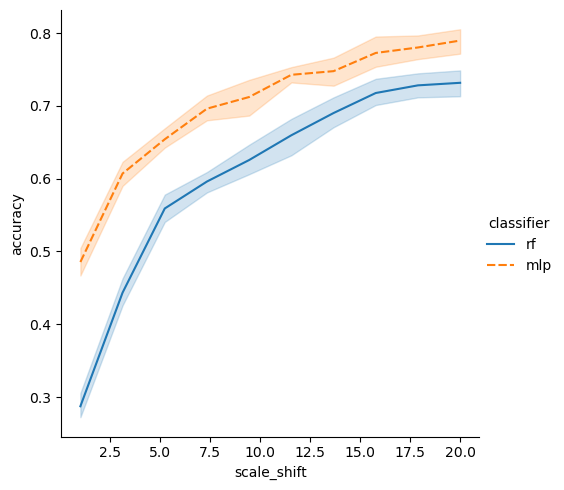

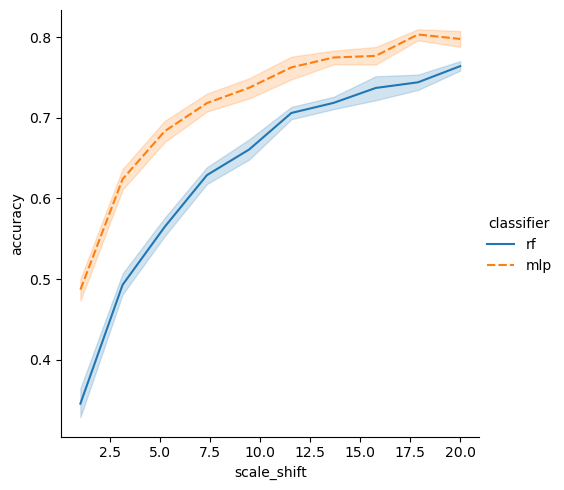

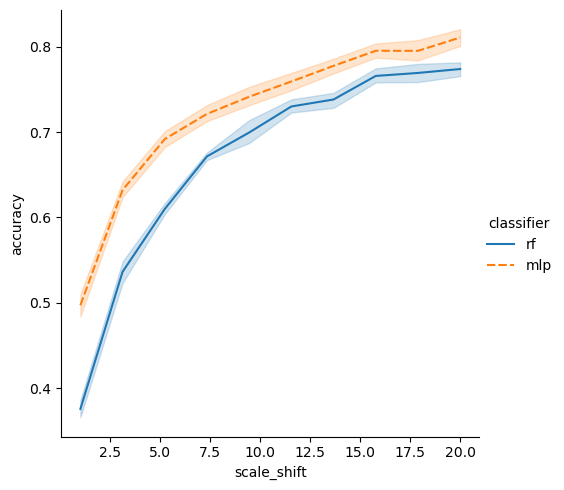

In [20]:
import seaborn as sns
for n in N:
    sns.relplot(
        data=dfs_scale[n], x="scale_shift", y="accuracy",
        hue="classifier", style="classifier", kind="line",
    )
    plt.show()
    # sns.relplot(
    #     data=dfs_scale[n], x="scale_shift", y="total_cv_time",
    #     hue="classifier", style="classifier", kind="line",
    # )
    # plt.show()

We choose the mlp and 5000 cal samples (2000 also ok).

#### Inference / Hypothesis Test
trained on cal set, evaluated in x_0

##### GOOD MAF

In [3]:
probas_good = torch.load('saved_experiments/Gaussian1d_localPIT/lc2st_results/probas_good_10000_rounds.pkl')
accuracy_good = []
for i in range(1000):
    accuracy_good.append(np.mean(np.array(probas_good[i])>=0.5))
np.mean(accuracy_good), np.std(accuracy_good)

(0.44487050000000006, 0.2221098063115404)

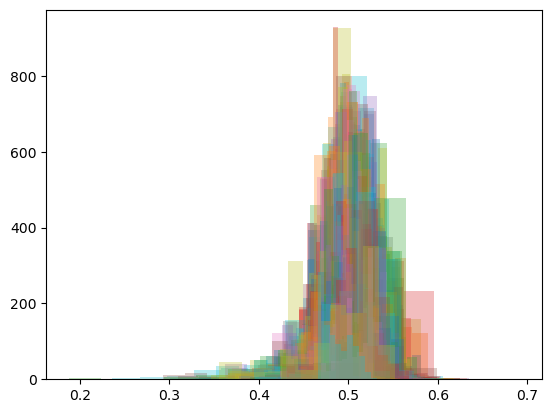

In [4]:
# results for x_0
n_trials = 1000
mean_good = torch.load('saved_experiments/Gaussian1d_localPIT/lc2st_results/mean_good.pkl')
std_good = torch.load('saved_experiments/Gaussian1d_localPIT/lc2st_results/std_good.pkl')
probas_good = torch.load('saved_experiments/Gaussian1d_localPIT/lc2st_results/probas_good.pkl')

for t in range(n_trials):
    plt.hist(probas_good[t],alpha=0.3)
plt.show()

##### BAD MAF

In [5]:
probas_bad = torch.load('saved_experiments/Gaussian1d_localPIT/lc2st_results/probas_bad_10000_rounds.pkl')
accuracy_bad = []
for i in range(1000):
    accuracy_bad.append(np.mean(np.array(probas_bad[i])>=0.5))
np.mean(accuracy_bad), np.std(accuracy_bad)

(0.5559165, 0.03559647788405477)

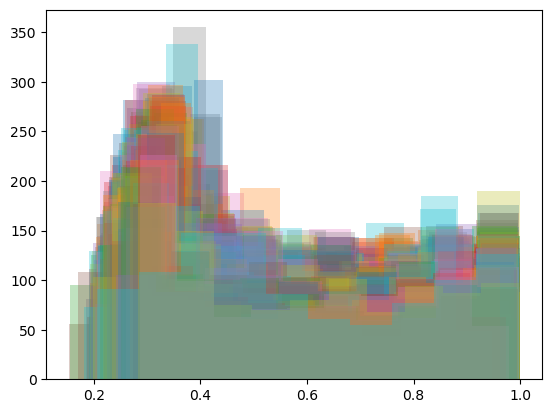

In [6]:
# results for x_0
n_trials = 1000
mean_bad = torch.load('saved_experiments/Gaussian1d_localPIT/lc2st_results/mean_bad.pkl')
std_bad = torch.load('saved_experiments/Gaussian1d_localPIT/lc2st_results/std_bad.pkl')
probas_bad = torch.load('saved_experiments/Gaussian1d_localPIT/lc2st_results/probas_bad.pkl')

for t in range(n_trials):
    plt.hist(probas_bad[t],alpha=0.3)
plt.show()

##### NULL Hypothesis

In [36]:
probas_null = torch.load('saved_experiments/Gaussian1d_localPIT/lc2st_results/probas_null_10000_rounds.pkl')
accuracy_null = []
for i in range(1000):
    accuracy_null.append(np.mean(np.array(probas_null[i])>=0.5))
np.mean(accuracy_null), np.std(accuracy_null)

(0.46888080000000004, 0.2682115156203402)

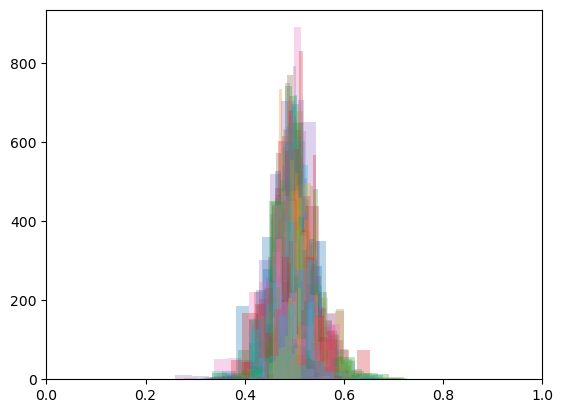

In [7]:
# results for x_0
n_trials = 1000

probas_null = torch.load('saved_experiments/Gaussian1d_localPIT/lc2st_results/probas_null.pkl')
mean_null = torch.load('saved_experiments/Gaussian1d_localPIT/lc2st_results/mean_null.pkl')
std_null = torch.load('saved_experiments/Gaussian1d_localPIT/lc2st_results/std_null.pkl')

for t in range(n_trials):
    plt.hist(probas_null[t],alpha=0.3)
    plt.xlim(0,1)
plt.show()

##### Confidence regions 

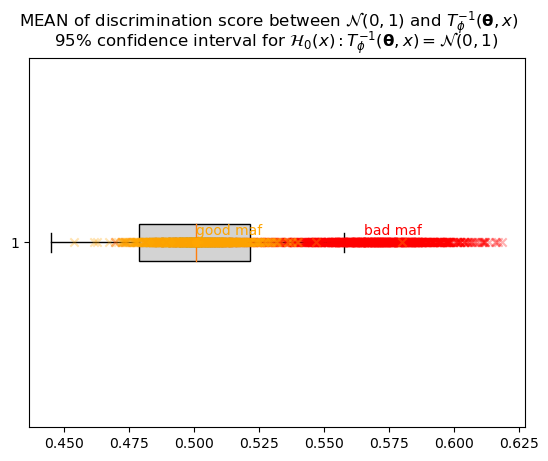

In [27]:
import matplotlib.cbook as cbook

data = mean_null
stats = cbook.boxplot_stats(data)[0]
stats['q1'] = np.quantile(data, 0.05)
stats['q3'] = np.quantile(data, 0.95)
stats['whislo'] = min(data)
stats['whishi'] = max(data)

fig, ax = plt.subplots(1, 1)
bp = ax.bxp([stats],widths=0.1, vert=False, showfliers=False, patch_artist=True)
bp['boxes'][0].set_facecolor('lightgray')

plt.text(np.mean(mean_good), 1.02, 'good maf', color='orange')
plt.scatter(np.mean(mean_good), 1, color='orange', zorder=10)
for m in mean_good:
    plt.scatter(m, 1, marker='x', color='orange', zorder=10, alpha=0.3)
plt.text(np.mean(mean_bad), 1.02, 'bad maf', color='red')
plt.scatter(np.mean(mean_bad), 1, color='red')
for m in mean_bad:
    plt.scatter(m, 1, marker='x', color='red', zorder=9, alpha=0.3)


# plt.legend()
plt.title(r'95% confidence interval for $\mathcal{H}_0(x) : T_{\phi}^{-1}(\mathbf{\theta}, x) = \mathcal{N}(0,1)$')
plt.suptitle(r'MEAN of discrimination score between $\mathcal{N}(0,1)$ and $T_{\phi}^{-1}(\mathbf{\theta}, x)$')
plt.show()

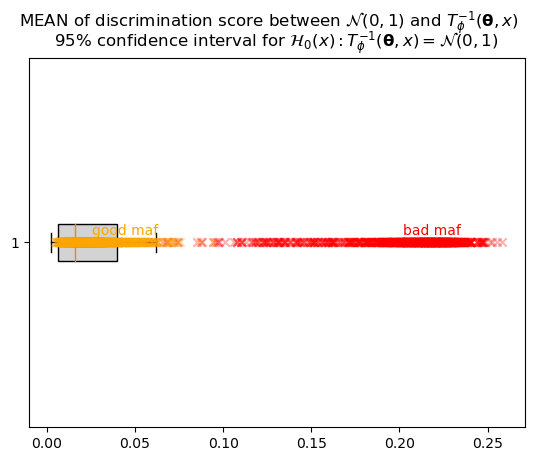

In [28]:
import matplotlib.cbook as cbook

data = std_null
stats = cbook.boxplot_stats(data)[0]
stats['q1'] = np.quantile(data, 0.05)
stats['q3'] = np.quantile(data, 0.95)
stats['whislo'] = min(data)
stats['whishi'] = max(data)

fig, ax = plt.subplots(1, 1)
bp = ax.bxp([stats],widths=0.1, vert=False, showfliers=False, patch_artist=True)
bp['boxes'][0].set_facecolor('lightgray')

plt.text(np.mean(std_good), 1.02, 'good maf', color='orange')
plt.scatter(np.mean(std_good), 1, color='orange', zorder=10)
for s in std_good:
    plt.scatter(s, 1, marker='x', color='orange', zorder=10, alpha=0.3)
plt.text(np.mean(std_bad), 1.02, 'bad maf', color='red')
plt.scatter(np.mean(std_bad), 1, color='red')
for s in std_bad:
    plt.scatter(s, 1, marker='x', color='red', zorder=9, alpha=0.3)


# plt.legend()
plt.title(r'95% confidence interval for $\mathcal{H}_0(x) : T_{\phi}^{-1}(\mathbf{\theta}, x) = \mathcal{N}(0,1)$')
plt.suptitle(r'MEAN of discrimination score between $\mathcal{N}(0,1)$ and $T_{\phi}^{-1}(\mathbf{\theta}, x)$')
plt.show()

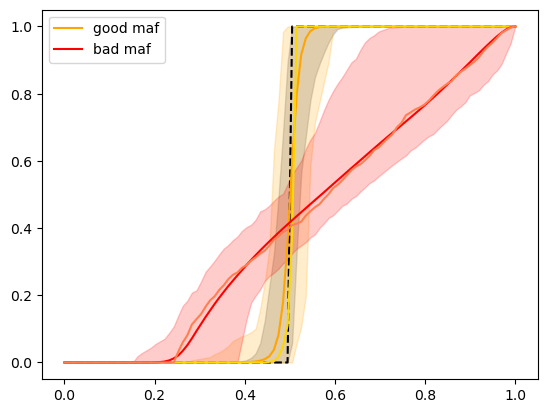

test stat good :  0.00401597
p-value good :  0.731

test stat bad :  0.07554588000000001
p-value bad :  0.0


In [10]:
random_run_idx = np.random.randint(0,1000)

alphas = np.linspace(0,1,100)
pp_vals_dirac = PP_vals([0.5]*1000, alphas)
plt.plot(alphas, pp_vals_dirac, '--', color='black')

pp_vals_null = {}
test_stats_null = {}
for t in range(len(probas_null)):
    pp_vals_null[t] = pd.Series(PP_vals(probas_null[t], alphas))
    test_stats_null[t] = ((pp_vals_null[t]- pp_vals_dirac) ** 2).sum() / len(alphas)

pp_vals_good = {}
pp_vals_bad = {}
for t in range(len(probas_null)):
    pp_vals_good[t] = pd.Series(PP_vals(probas_good[t], alphas))
    pp_vals_bad[t] = pd.Series(PP_vals(probas_bad[t], alphas))

low_null = pd.DataFrame(pp_vals_null).quantile(0.05/2, axis=1)
up_null = pd.DataFrame(pp_vals_null).quantile(1-0.05/2, axis=1)
plt.fill_between(alphas, low_null, up_null, color="grey", alpha=0.3)

low_good = pd.DataFrame(pp_vals_good).min(axis=1)
up_good = pd.DataFrame(pp_vals_good).max(axis=1)
line_good = pd.DataFrame(pp_vals_good).mean(axis=1)
plt.plot(alphas, line_good, label='good maf', color='orange')
plt.plot(alphas, pp_vals_good[random_run_idx], color='gold')
plt.fill_between(alphas, low_good, up_good, color="orange", alpha=0.2)

low_bad = pd.DataFrame(pp_vals_bad).min(axis=1)
up_bad = pd.DataFrame(pp_vals_bad).max(axis=1)
line_bad = pd.DataFrame(pp_vals_bad).mean(axis=1)
plt.plot(alphas, line_bad, label='bad maf', color='red')
plt.plot(alphas, pp_vals_bad[random_run_idx], color='coral')
plt.fill_between(alphas, low_bad, up_bad, color="red", alpha=0.2)
plt.legend()
plt.show()

test_stat_good = ((pp_vals_good[random_run_idx] - pp_vals_dirac) ** 2).sum() / len(alphas)
p_value_good = sum(1 * (test_stat_good < pd.Series(test_stats_null))) / len(test_stats_null)
print('test stat good : ', test_stat_good)
print('p-value good : ', p_value_good)
print()

test_stat_bad = ((pp_vals_bad[random_run_idx] - pp_vals_dirac) ** 2).sum() / len(alphas)
p_value_bad = sum(1 * (test_stat_bad < pd.Series(test_stats_null))) / len(test_stats_null)
print('test stat bad : ', test_stat_bad)
print('p-value bad : ', p_value_bad)


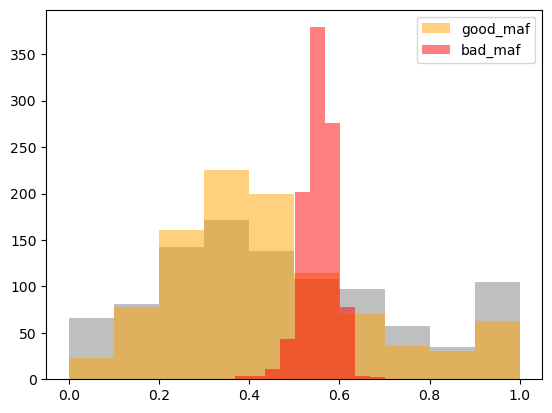

In [38]:
plt.hist(accuracy_null, color='grey', alpha=0.5)
plt.hist(accuracy_good, color='orange', alpha=0.5, label='good_maf')
plt.hist(accuracy_bad, color='red', alpha=0.5, label='bad_maf')
plt.legend()
plt.show()

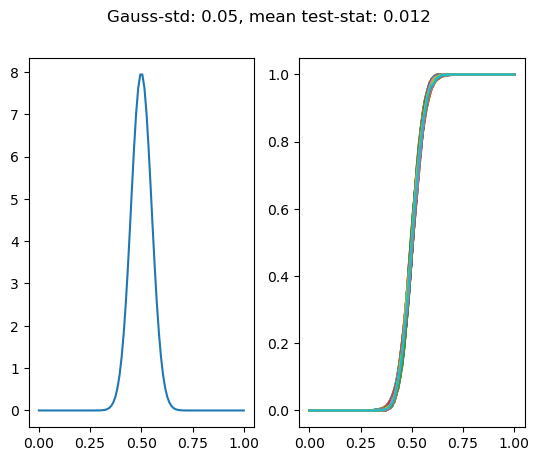

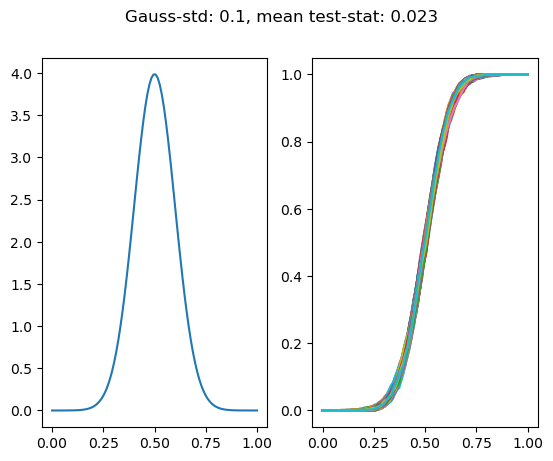

In [82]:
def smooth_dirac(eps=0.1):
    return norm(loc=0.5,scale=eps)

alphas = np.linspace(0,1,100)
for e in [0.05, 0.1]:
    fig, axs = plt.subplots(1,2)
    axs[0].plot(alphas,[smooth_dirac(eps=e).pdf(x) for x in alphas])

    pp_vals_dirac = PP_vals([0.5]*1000, alphas)

    test_stats = []
    for t in range(1000):
        samples = smooth_dirac(eps=e).rvs(1000)
        pp_vals = pd.Series(PP_vals(samples, alphas))
        test_stats.append(((pp_vals - pp_vals_dirac) ** 2).sum() / len(alphas))
        axs[1].plot(alphas, pp_vals)
    plt.suptitle(f'Gauss-std: {e}, mean test-stat: {np.round(np.mean(test_stats),3)}')
    plt.show()

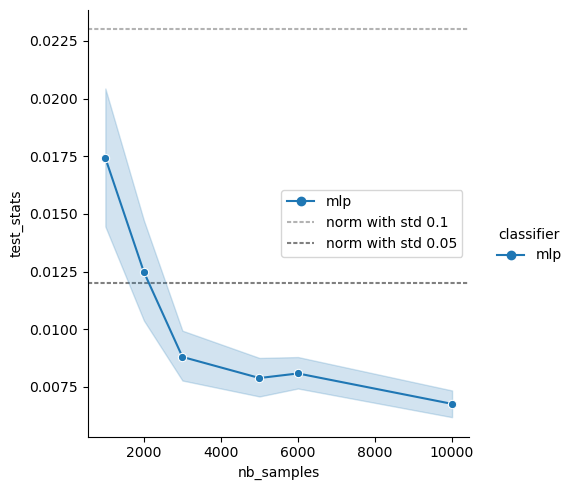

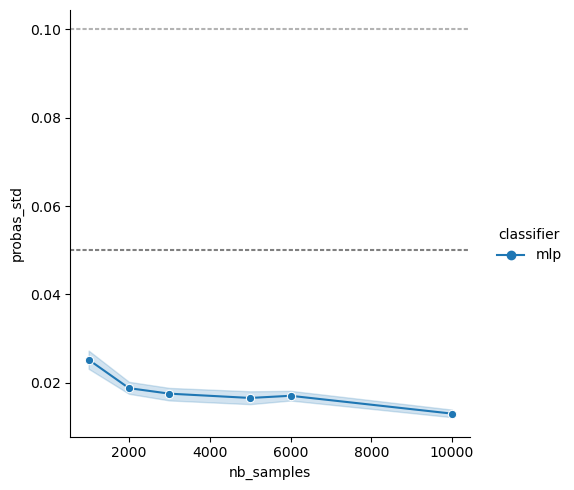

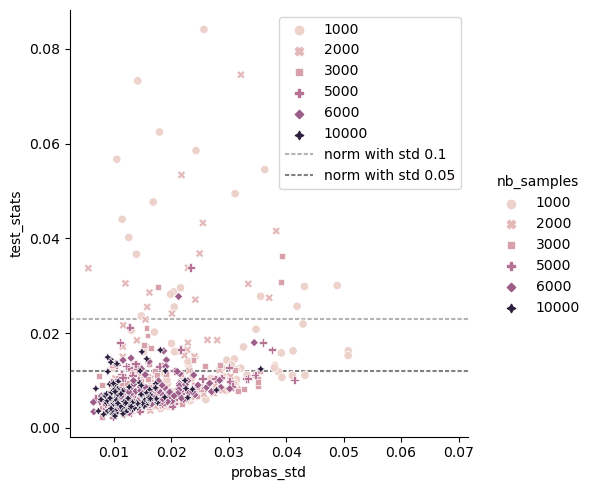

(0.05080683914882537, 0.04328133866296062)

In [103]:
import seaborn as sns
import torch
import pandas as pd
import matplotlib.pyplot as plt

dfs = []
for n in [1000, 2000, 3000, 5000, 6000, 10000]:
    dfs.append(torch.load(f'saved_experiments/Gaussian1d_localPIT/lc2st_eval_clfs/df_null_std_cv_n_[{n}]_ntrials_100_Tstats.pkl'))

df = pd.concat(dfs, ignore_index=True)

g = sns.relplot(
        data=df, x="nb_samples", y="test_stats",
        hue="classifier", style="classifier", kind="line", markers='o'
    )
g.map(plt.axhline, y=0.023, color=".7", dashes=(2, 1), zorder=0, label='norm with std 0.1')
g.map(plt.axhline, y=0.012, color=".5", dashes=(2, 1), zorder=0, label='norm with std 0.05')
plt.legend()
plt.show()

g = sns.relplot(
        data=df, x="nb_samples", y="probas_std",
        hue="classifier", style="classifier", kind="line", markers='o'
    )
g.map(plt.axhline, y=0.1, color=".7", dashes=(2, 1), zorder=0)
g.map(plt.axhline, y=0.05, color=".5", dashes=(2, 1), zorder=0)
plt.show()

g = sns.relplot(
        data=df, x="probas_std", y="test_stats",
        hue="nb_samples", style="nb_samples", kind="scatter", 
    )
g.map(plt.axhline, y=0.023, color=".7", dashes=(2, 1), zorder=0, label='norm with std 0.1')
g.map(plt.axhline, y=0.012, color=".5", dashes=(2, 1), zorder=0, label='norm with std 0.05')
plt.legend()
plt.show()
df[df['test_stats']<=0.023]['probas_std'].max(), df[df['test_stats']<=0.012]['probas_std'].max()

Results:
- plot 1: the wanted test statistics are obtained for a sample size of 2-3_000 (for 0.05 std) and always for 0.1 std
- plot 2: the predicted proba std is always below 0.1 and 0.05 (95% CI)
- plot 3: Larger sample sizes ensure small test statistics for small stds (closer to theory). There are no data points that deviate from the theory (see printed max stds below plot that are respectively smaller than 0.1 and 0.05)

What sample size do we chose? the smallest one to obtain best accuracy for shift-experiment --> 2000? 5000?